# Feature Learning Example Code

We will use Medicare Part B payment data from 2015, limited to providers in Miami due to dataset size (see make-data.ipynb).

The goal will be to create a feature space that can model each provider's specialty based on the procedures they perform.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

random_state = 42

sns.set(style='whitegrid', palette='Set2')

# Get data



In [2]:
df = pd.read_csv('https://s3.amazonaws.com/rikturr/2015_partB_miami.txt', sep='\t')

# Exploratory analysis

In [3]:
df.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
0,1003011107,STANDHART,PHILIP,L,"MSPT, CSCS",M,I,3841 E TAMIAMI TRL,NaN,NAPLES,...,97001,Physical therapy evaluation,N,217.0,199,217,77.583318,165.0,57.633272,56.304700
1,1003011107,STANDHART,PHILIP,L,"MSPT, CSCS",M,I,3841 E TAMIAMI TRL,NaN,NAPLES,...,97035,"Application of ultrasound to 1 or more areas, ...",N,205.0,33,205,10.721707,29.0,8.284585,8.050439
2,1003011107,STANDHART,PHILIP,L,"MSPT, CSCS",M,I,3841 E TAMIAMI TRL,NaN,NAPLES,...,97110,"Therapeutic exercise to develop strength, endu...",N,4643.0,217,2442,28.992406,63.0,22.384523,19.457097
3,1003011107,STANDHART,PHILIP,L,"MSPT, CSCS",M,I,3841 E TAMIAMI TRL,NaN,NAPLES,...,97112,Therapeutic procedure to re-educate brain-to-n...,N,164.0,16,164,34.376646,45.0,26.949390,26.438780
4,1003011107,STANDHART,PHILIP,L,"MSPT, CSCS",M,I,3841 E TAMIAMI TRL,NaN,NAPLES,...,97140,Manual (physical) therapy techniques to 1 or m...,N,2030.0,199,2029,23.383468,60.0,18.179355,19.014739


In [4]:
df.dtypes

npi                                   int64
nppes_provider_last_org_name         object
nppes_provider_first_name            object
nppes_provider_mi                    object
nppes_credentials                    object
nppes_provider_gender                object
nppes_entity_code                    object
nppes_provider_street1               object
nppes_provider_street2               object
nppes_provider_city                  object
nppes_provider_zip                    int64
nppes_provider_state                 object
nppes_provider_country               object
provider_type                        object
medicare_participation_indicator     object
place_of_service                     object
hcpcs_code                           object
hcpcs_description                    object
hcpcs_drug_indicator                 object
line_srvc_cnt                       float64
bene_unique_cnt                       int64
bene_day_srvc_cnt                     int64
average_Medicare_allowed_amt    

In [5]:
df['nppes_provider_city'].value_counts()

MIAMI                 31353
MIAMI BEACH            4380
SARASOTA               3276
PORT CHARLOTTE         3005
SOUTH MIAMI            2943
NAPLES                 1886
VENICE                 1243
NORTH MIAMI BEACH      1198
NORTH PORT              606
NORTH MIAMI             521
MIAMI LAKES             366
MIAMI SHORES            282
BONITA SPRINGS          258
OSPREY                  249
PUNTA GORDA             115
NOKOMIS                 101
ESTERO                   81
WEST MIAMI               76
FORT MYERS               71
N MIAMI BEACH            69
MIAMI GARDENS            65
NORTH FORT MYERS         40
NORTH MIAMI BCH          32
PALM BEACH GARDENS       27
PT. CHARLOTTE            25
MIAMI SPRINGS            23
RUSKIN                   20
AVENTURA                 14
HIALEAH                  12
S MIAMI                  10
NORTH FT MYERS           10
DELRAY BEACH              7
CORAL GABLES              7
N FT MYERS                6
INDIALANTIC               6
ATLANTIS            

In [6]:
miami = df[df['nppes_provider_city'].str.contains('MIAMI')]
miami['nppes_provider_city'].value_counts()

MIAMI                31353
MIAMI BEACH           4380
SOUTH MIAMI           2943
NORTH MIAMI BEACH     1198
NORTH MIAMI            521
MIAMI LAKES            366
MIAMI SHORES           282
WEST MIAMI              76
N MIAMI BEACH           69
MIAMI GARDENS           65
NORTH MIAMI BCH         32
MIAMI SPRINGS           23
S MIAMI                 10
N MIAMI                  2
Name: nppes_provider_city, dtype: int64

In [7]:
miami.describe()

,npi,nppes_provider_zip,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
count,4.132000e+04,4.132000e+04,41320.000000,41320.000000,41320.000000,41320.000000,41320.000000,41320.000000,41320.000000
mean,1.501450e+09,3.069520e+08,235.051479,85.978896,150.170741,118.163017,412.125637,90.737539,85.683546
std,2.892670e+08,8.679978e+07,3197.242224,319.521669,843.780808,274.323432,1036.620731,214.425918,202.304966
min,1.003017e+09,3.301400e+04,11.000000,11.000000,11.000000,0.019448,0.150000,0.013235,0.013235
25%,1.255352e+09,3.313610e+08,21.000000,17.000000,20.000000,34.360356,92.839713,26.174299,25.270133
50%,1.508033e+09,3.314046e+08,44.000000,33.000000,41.000000,77.535684,188.765244,59.208995,57.251866
75%,1.750349e+09,3.317335e+08,115.000000,73.000000,104.000000,131.498758,373.487419,100.889890,96.480444
max,1.992998e+09,3.319935e+08,493024.300000,14193.000000,90989.000000,15841.578667,44203.600000,12419.794667,11938.110000


In [8]:
miami.shape

(41320, 26)

In [9]:
miami['npi'].nunique()

4933

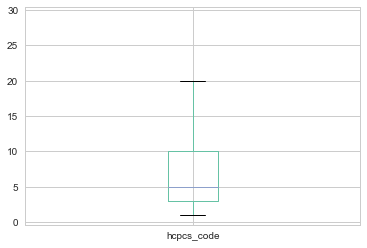

In [11]:
num_hcpcs_per_doc = miami.groupby('npi')['hcpcs_code'].nunique()
num_hcpcs_per_doc[num_hcpcs_per_doc < 30].plot(kind='box')

In [12]:
provider_types = miami['provider_type'].value_counts().reset_index()
provider_types.columns = ['provider_type', 'count']
provider_types

,provider_type,count
0,Internal Medicine,5035
1,Diagnostic Radiology,5021
2,Cardiology,2594
3,Ophthalmology,2005
4,Family Practice,1680
5,Podiatry,1470
6,Clinical Laboratory,1172
7,Dermatology,1078
8,Gastroenterology,1050
9,Orthopedic Surgery,1030


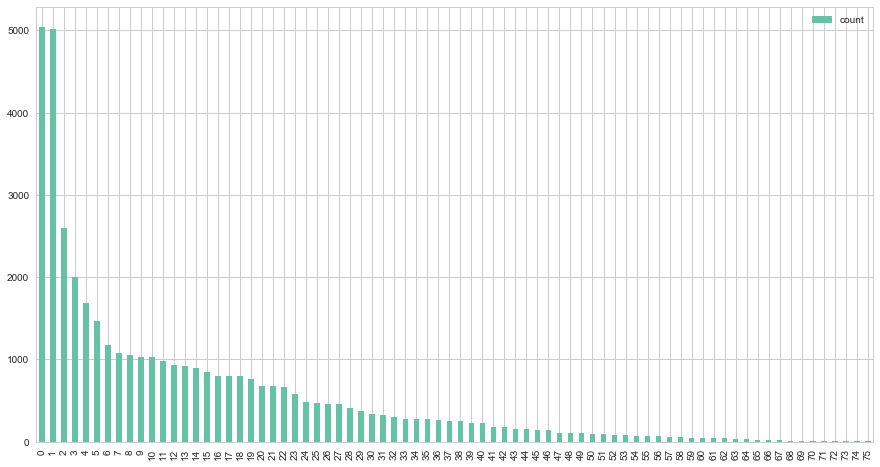

In [13]:
provider_types.plot(kind='bar', figsize=(15, 8))

In [14]:
miami['place_of_service'].value_counts()

O    22358
F    18962
Name: place_of_service, dtype: int64

# Create dataset for modeling

* take top 30 specialty types
* collapse place_of_service
* one-hot encoding

In [15]:
top_type = provider_types[provider_types.index <= 10]
miami['hcpcs'] = miami['hcpcs_code'] + ' (' + miami['hcpcs_description'] + ')'
clean = (miami[miami['provider_type'].isin(top_type['provider_type'])]
         .groupby(['npi', 'provider_type', 'hcpcs'])['line_srvc_cnt'].sum()
         .reset_index())

/Users/aaron.richter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
clean.head()

,npi,provider_type,hcpcs,line_srvc_cnt
0,1003017112,Internal Medicine,93000 (Routine EKG using at least 12 leads inc...,19.0
1,1003017112,Internal Medicine,93010 (Routine electrocardiogram (EKG) using a...,369.0
2,1003017112,Internal Medicine,93016 (Exercise or drug-induced heart and bloo...,27.0
3,1003017112,Internal Medicine,93018 (Exercise or drug-induced heart and bloo...,31.0
4,1003017112,Internal Medicine,93306 (Ultrasound examination of heart includi...,208.0


In [17]:
clean.shape

(22239, 4)

In [18]:
clean.describe()

,npi,line_srvc_cnt
count,2.223900e+04,22239.000000
mean,1.497075e+09,235.269958
std,2.888026e+08,3966.029474
min,1.003017e+09,11.000000
25%,1.255395e+09,21.000000
50%,1.487691e+09,43.000000
75%,1.740242e+09,116.000000
max,1.992994e+09,493024.300000


In [19]:
pd.set_option('display.max_colwidth', 100)
clean['hcpcs'].value_counts().reset_index()

,index,hcpcs
0,"99213 (Established patient office or other outpatient visit, typically 15 minutes)",1009
1,"99214 (Established patient office or other outpatient, visit typically 25 minutes)",925
2,"99232 (Subsequent hospital inpatient care, typically 25 minutes per day)",582
3,"99204 (New patient office or other outpatient visit, typically 45 minutes)",485
4,"99223 (Initial hospital inpatient care, typically 70 minutes per day)",452
5,"99203 (New patient office or other outpatient visit, typically 30 minutes)",426
6,"99233 (Subsequent hospital inpatient care, typically 35 minutes per day)",404
7,"99222 (Initial hospital inpatient care, typically 50 minutes per day)",371
8,36415 (Insertion of needle into vein for collection of blood sample),370
9,93000 (Routine EKG using at least 12 leads including interpretation and report),369


In [20]:
one_hot = (clean
           .pivot_table(index=['npi', 'provider_type'], columns='hcpcs', values='line_srvc_cnt')
           .reset_index()
           .fillna(0))
one_hot['provider_type'] = one_hot['provider_type'].astype('category')

In [21]:
one_hot.shape

(2062, 1366)

In [22]:
one_hot.head()

hcpcs,npi,provider_type,00103 (Anesthesia for procedure on eyelid),00104 (Anesthesia for electric shock treatment),00120 (Anesthesia for biopsy of external middle and inner ear),00140 (Anesthesia for procedure on eye),00142 (Anesthesia for lens surgery),00144 (Anesthesia for procedure on eye for corneal transplant),00145 (Anesthesia for retinal surgery),00160 (Anesthesia for procedure on nose and sinus),...,"Q2035 (Influenza virus vaccine, split virus, when administered to individuals 3 years of age and older, for intramuscular use (afluria))","Q2037 (Influenza virus vaccine, split virus, when administered to individuals 3 years of age and older, for intramuscular use (fluvirin))","Q2038 (Influenza virus vaccine, split virus, when administered to individuals 3 years of age and older, for intramuscular use (fluzone))","Q4006 (Cast supplies, long arm cast, adult (11 years +), fiberglass)","Q4010 (Cast supplies, short arm cast, adult (11 years +), fiberglass)","Q4014 (Cast supplies, gauntlet cast (includes lower forearm and hand), adult (11 years +), fiberglass)","Q4021 (Cast supplies, short arm splint, adult (11 years +), plaster)","Q9960 (High osmolar contrast material, 200-249 mg/ml iodine concentration, per ml)","Q9967 (Low osmolar contrast material, 300-399 mg/ml iodine concentration, per ml)","Q9977 (Compounded Drug, Not Otherwise Classified)"
0,1003017112,Internal Medicine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003046962,Internal Medicine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003064270,Internal Medicine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003064791,Anesthesiology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003115155,Diagnostic Radiology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
one_hot_matrix = one_hot.drop(['npi', 'provider_type'], axis=1).values
one_hot_matrix.nbytes / 1024 / 1024

21.45819091796875

In [24]:
one_hot_matrix.shape

(2062, 1364)

In [25]:
lookup = one_hot[['npi', 'provider_type']]

## Aside - sparse

With real data, there will be too many zeros in dense matrix -> need to use sparse matrix

With keras, need to use a generator function: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html

Not using in this notebook, just for reference

In [26]:
from scipy import sparse as sp
sparse = sp.csc_matrix(one_hot_matrix)
sparse

<2062x1364 sparse matrix of type '<class 'numpy.float64'>'
	with 22239 stored elements in Compressed Sparse Column format>

In [27]:
def sparse_generator(x, y=None, batch_size=32):
    index = np.arange(x.shape[0])
    start = 0
    while True:
        if start == 0 and y is not None:
            np.random.shuffle(index)
            
        batch = index[start:start+batch_size]
        
        if y is not None:
            yield x[batch].toarray(), y[batch].toarray()
        else:
            yield x[batch].toarray()
            
        start += batch_size
        if start >= x.shape[0]:
            start = 0

# Preprocessing

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(one_hot_matrix)

# PCA

In [29]:
from sklearn.decomposition import PCA

pca = PCA()
pca_transformed = pca.fit_transform(scaled)

In [30]:
pca_transformed

array([[ -4.83131255e-01,   6.47942456e-02,  -1.04112328e-01, ...,
          1.39206070e-16,  -8.22705111e-17,  -2.18971753e-17],
       [ -4.78470992e-01,   6.34579717e-02,  -1.01451011e-01, ...,
          1.76106328e-17,   2.76642095e-17,   5.99627950e-18],
       [ -4.84992349e-01,   6.51292516e-02,  -1.04679661e-01, ...,
          1.15623415e-17,  -4.11726533e-19,  -7.63018950e-19],
       ..., 
       [ -4.87286469e-01,   6.58263393e-02,  -1.05654938e-01, ...,
         -1.99307397e-17,  -6.09008172e-17,  -3.17927231e-17],
       [ -4.66254849e-01,   6.01174175e-02,  -9.54365251e-02, ...,
          4.65431012e-18,  -1.47929189e-17,  -5.11424914e-18],
       [ -4.94336940e-01,   7.13951019e-02,  -1.18386630e-01, ...,
         -8.46648418e-18,  -9.90848228e-18,   1.86420866e-18]])

Text(0,0.5,'Proportion of explained variance')

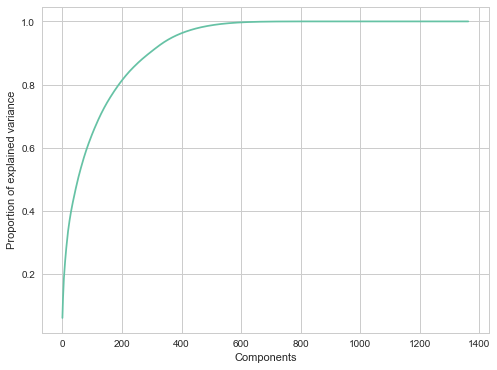

In [31]:
scree = pd.DataFrame({'var': pca.explained_variance_ratio_,
                      'cumvar': np.cumsum(pca.explained_variance_ratio_)})
plt.figure(figsize=(8,6))
scree['cumvar'].plot()
plt.xlabel('Components')
plt.ylabel('Proportion of explained variance')

In [32]:
def transformed_df(x, lookup_df=lookup):
    df = pd.DataFrame(x)
    df.columns = ['{}'.format(i) for i in range(len(df.columns))]
    return lookup_df.merge(df, left_index=True, right_index=True)

def scatter_clusters(df):
    sns.lmplot(data=df, x='0', y='1', hue='provider_type', 
               palette='Set2', fit_reg=False, size=8)

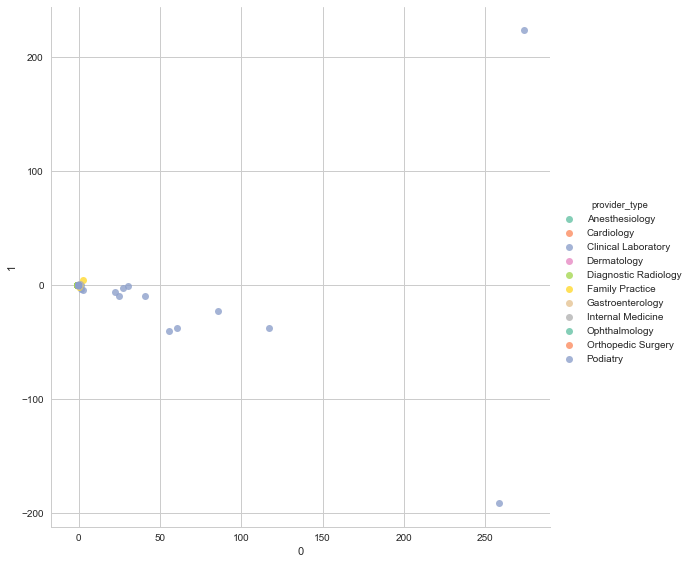

In [33]:
pca_df = transformed_df(pca_transformed[:, :2])
scatter_clusters(pca_df)

In [34]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=10, early_exaggeration=30, random_state=random_state)

pca_tsne = tsne.fit_transform(pca_transformed[:, :50])
pca_tsne_df = transformed_df(pca_tsne)

CPU times: user 29.7 s, sys: 3.32 s, total: 33 s
Wall time: 33.1 s


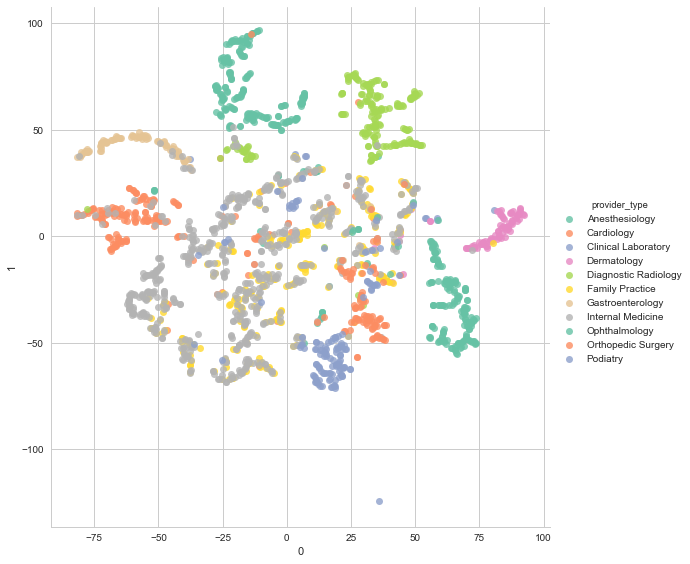

In [35]:
scatter_clusters(pca_tsne_df)

# Autoencoder

In [36]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *

def autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(500, activation='relu')(input_layer)
    encoded = Dense(50, activation='relu', name='encoded')(encoded)
    decoded = Dense(500, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    model = Model(input_layer, decoded)
    return model

deep_ae = autoencoder(scaled.shape[1])
deep_ae.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1364)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               682500    
_________________________________________________________________
encoded (Dense)              (None, 50)                25050     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               25500     
_________________________________________________________________
dense_3 (Dense)              (None, 1364)              683364    
Total params: 1,416,414
Trainable params: 1,416,414
Non-trainable params: 0
_________________________________________________________________


In [37]:
%%time
deep_ae.compile(optimizer='sgd', loss='mse')
deep_ae.fit(scaled, scaled, epochs=50, validation_split=0.1)

Train on 1855 samples, validate on 207 samples
Epoch 1/50
1855/1855 [==============================] - 1s 344us/step - loss: 1.2055 - val_loss: 1.6597
Epoch 2/50
1855/1855 [==============================] - 1s 359us/step - loss: 1.2053 - val_loss: 1.6596
Epoch 3/50
1855/1855 [==============================] - 0s 252us/step - loss: 1.2051 - val_loss: 1.6594
Epoch 4/50
1855/1855 [==============================] - 0s 269us/step - loss: 1.2049 - val_loss: 1.6593
Epoch 5/50
1855/1855 [==============================] - 0s 259us/step - loss: 1.2047 - val_loss: 1.6592
Epoch 6/50
1855/1855 [==============================] - 1s 295us/step - loss: 1.2046 - val_loss: 1.6591
Epoch 7/50
1855/1855 [==============================] - 0s 252us/step - loss: 1.2044 - val_loss: 1.6590
Epoch 8/50
1855/1855 [==============================] - 1s 338us/step - loss: 1.2042 - val_loss: 1.6589
Epoch 9/50
1855/1855 [==============================] - 0s 268us/step - loss: 1.2040 - val_loss: 1.6587
Epoch 10/50
1855/

In [38]:
deep_encoder = Model(deep_ae.layers[0].input, deep_ae.get_layer('encoded').output)
deep_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1364)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               682500    
_________________________________________________________________
encoded (Dense)              (None, 50)                25050     
Total params: 707,550
Trainable params: 707,550
Non-trainable params: 0
_________________________________________________________________


In [39]:
ae_transformed = deep_encoder.predict(scaled)
ae_transformed.shape

(2062, 50)

In [40]:
%%time
ae_tsne = tsne.fit_transform(ae_transformed)
ae_tsne_df = transformed_df(ae_tsne)

CPU times: user 32.7 s, sys: 4.71 s, total: 37.4 s
Wall time: 37.5 s


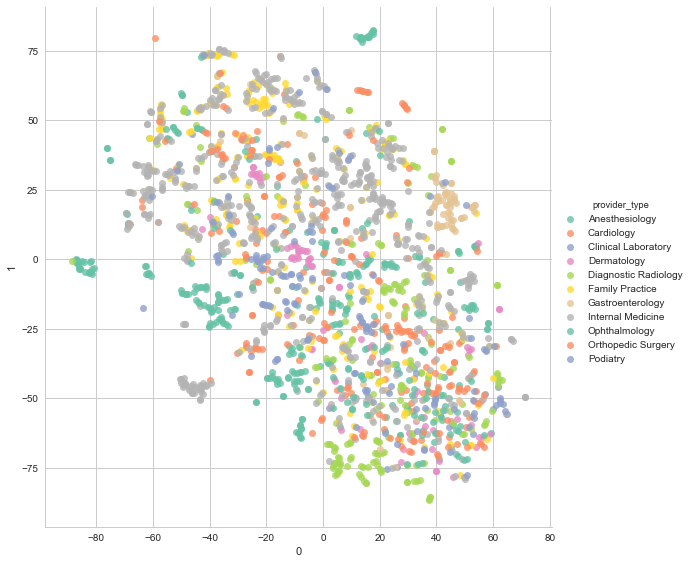

In [41]:
scatter_clusters(ae_tsne_df)

# Supervised Training

In [42]:
from keras.utils import to_categorical

prov_type = to_categorical(one_hot['provider_type'].cat.codes)
prov_type.shape

(2062, 11)

In [43]:
def deep_mlp(input_dim, output_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(500, activation='relu')(input_layer)
    x = Dense(100, activation='relu')(x)
    x = Dense(50, activation='relu', name='encoded')(x)
    output_layer = Dense(output_dim, activation='softmax')(x)

    model = Model(input_layer, output_layer)
    return model

In [44]:
mlp = deep_mlp(scaled.shape[1], prov_type.shape[1])
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1364)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               682500    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               50100     
_________________________________________________________________
encoded (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_6 (Dense)              (None, 11)                561       
Total params: 738,211
Trainable params: 738,211
Non-trainable params: 0
_________________________________________________________________


In [45]:
%%time
mlp.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
mlp.fit(scaled, prov_type, epochs=50, validation_split=0.1)

Train on 1855 samples, validate on 207 samples
Epoch 1/50
1855/1855 [==============================] - 0s 175us/step - loss: 2.3396 - acc: 0.2911 - val_loss: 2.1445 - val_acc: 0.3623
Epoch 2/50
1855/1855 [==============================] - 0s 137us/step - loss: 1.8894 - acc: 0.4588 - val_loss: 1.8748 - val_acc: 0.4493
Epoch 3/50
1855/1855 [==============================] - 0s 126us/step - loss: 1.5653 - acc: 0.5461 - val_loss: 1.6499 - val_acc: 0.4976
Epoch 4/50
1855/1855 [==============================] - 0s 139us/step - loss: 1.3182 - acc: 0.6194 - val_loss: 1.4768 - val_acc: 0.5507
Epoch 5/50
1855/1855 [==============================] - 0s 135us/step - loss: 1.1385 - acc: 0.6647 - val_loss: 1.3526 - val_acc: 0.5942
Epoch 6/50
1855/1855 [==============================] - 0s 131us/step - loss: 1.0075 - acc: 0.6954 - val_loss: 1.2729 - val_acc: 0.6377
Epoch 7/50
1855/1855 [==============================] - 0s 134us/step - loss: 0.9083 - acc: 0.7283 - val_loss: 1.1994 - val_acc: 0.6570
E

In [46]:
predicted = mlp.predict(scaled)
predicted_class = np.argmax(predicted, axis=1)
true_class = np.argmax(prov_type, axis=1)

In [47]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(true_class, predicted_class,
                            target_names=list(one_hot['provider_type'].cat.categories)))

                      precision    recall  f1-score   support

      Anesthesiology       0.97      0.95      0.96       221
          Cardiology       0.97      0.88      0.92       169
 Clinical Laboratory       1.00      0.85      0.92        20
         Dermatology       0.96      0.92      0.94        85
Diagnostic Radiology       0.99      0.95      0.97       195
     Family Practice       0.60      0.64      0.62       259
    Gastroenterology       0.98      0.93      0.95        94
   Internal Medicine       0.82      0.89      0.85       633
       Ophthalmology       0.99      0.91      0.95       168
  Orthopedic Surgery       1.00      0.81      0.90        91
            Podiatry       0.98      0.92      0.95       127

         avg / total       0.88      0.87      0.88      2062



In [48]:
pd.set_option('display.width', 100)
from pandas_ml import ConfusionMatrix
prov_mapping = {i: c for i, c in enumerate(one_hot['provider_type'].dtype.categories)}

ConfusionMatrix([prov_mapping[x] for x in true_class], [prov_mapping[x] for x in predicted_class])

Predicted             Anesthesiology  Cardiology  Clinical Laboratory  Dermatology  \
Actual                                                                               
Anesthesiology                   211           0                    0            0   
Cardiology                         0         149                    0            0   
Clinical Laboratory                0           0                   17            1   
Dermatology                        0           0                    0           78   
Diagnostic Radiology               2           0                    0            0   
Family Practice                    1           0                    0            1   
Gastroenterology                   0           0                    0            0   
Internal Medicine                  3           5                    0            0   
Ophthalmology                      0           0                    0            0   
Orthopedic Surgery                 0           0      

In [49]:
mlp_encoder = Model(mlp.layers[0].input, mlp.get_layer('encoded').output)
mlp_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1364)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               682500    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               50100     
_________________________________________________________________
encoded (Dense)              (None, 50)                5050      
Total params: 737,650
Trainable params: 737,650
Non-trainable params: 0
_________________________________________________________________


In [50]:
mlp_transformed = mlp_encoder.predict(scaled)
mlp_transformed.shape

(2062, 50)

In [51]:
%%time
mlp_tsne = tsne.fit_transform(mlp_transformed)
mlp_tsne_df = transformed_df(mlp_tsne)

CPU times: user 26.9 s, sys: 4.61 s, total: 31.5 s
Wall time: 31.6 s


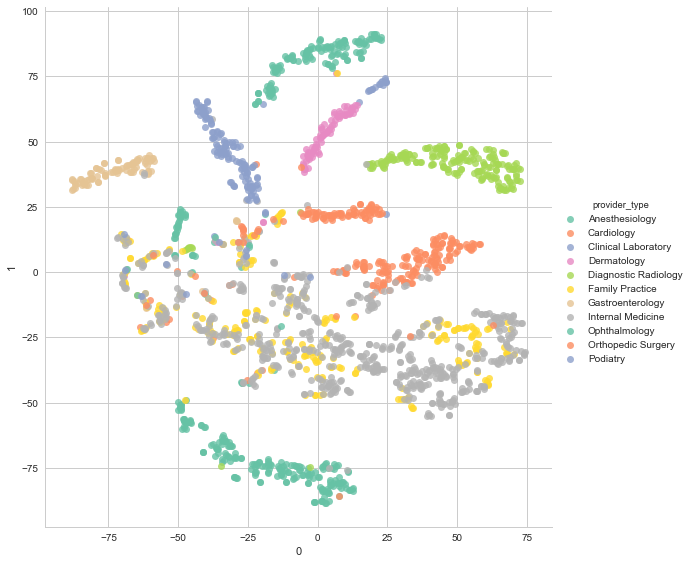

In [52]:
scatter_clusters(mlp_tsne_df)

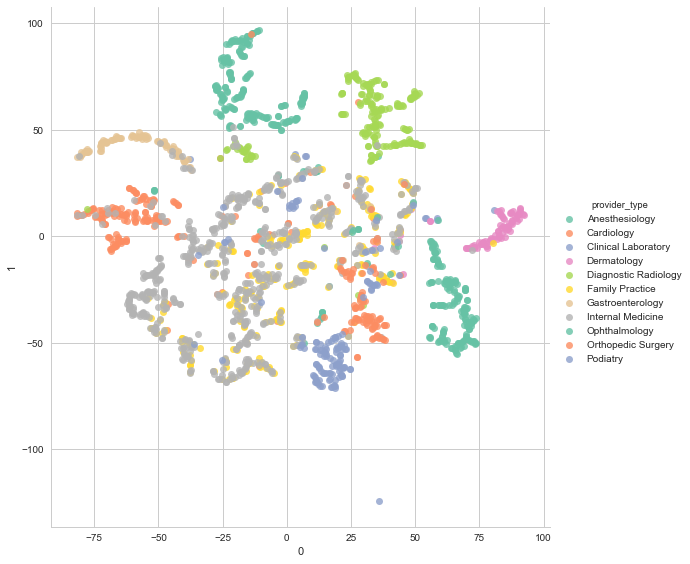

In [53]:
scatter_clusters(pca_tsne_df)